# Valvestate DSP

This document describes the design process of the DSP algorithms for the plugin.
[Schematics](https://drtube.com/schematics/marshall/pc0689.pdf)

In [1]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import csv
import sympy
import re

In [2]:
# Sample rate to use when plotting digital filter responses
rate = 48000
# Bilinear transform parameter, optimal at DC
k = 2*rate

# Default plot settings
plt.rcParams["figure.figsize"] = (14, 7)
plt.rcParams['axes.grid'] = True

from sympy.abc import s, z, K

# Filters

Analog filters are discretectised using the method described in [DISCRETIZATION OF THE ’59 FENDER BASSMAN TONE STACK by David T. Yeh, Julius O. Smith](https://ccrma.stanford.edu/~dtyeh/papers/yeh06_dafx.pdf).

In summary, symbolic analysis is performed on the schematic in the s-domain, then the bilinear transform is used to genereate a z-domain transfer function, which can be implemented as an IIR filter.

They gloss over how exactly to perform the symbolic circuit analysis. I have used QSapecNG for this. This software performs symbolic analysis on a graphical schematic, so it is quite easy to use. Unfortunately it has many bugs, and is not maintained anymore. Schematics are available for each circuit under the file mentioned in the relevant code snippet.

[Lcapy](https://github.com/mph-/lcapy), [ahkab](https://github.com/ahkab/ahkab), [SCAM](https://github.com/echeever/scam), Wolfram SystemModeler could possibly work here. I have only tried lcapy, and altough it would be nice to do all the work inside Python, it was too slow to be usable.

In [3]:
def print_as_cpp_coefficients(coeffs, name):
    for i in range(len(coeffs)):    
        tmp = f"float {name}{i} = {coeffs[i]};"
        # substitute python power syntax a**2 to std::pow(a, 2)
        print(re.sub(r"([a-zA-Z])\*\*(\d)", r"std::pow(\1, \2)", tmp))
    
print_as_cpp_coefficients(range(0, 3), "test")
print_as_cpp_coefficients([s**5], "power")

float test0 = 0;
float test1 = 1;
float test2 = 2;
float power0 = std::pow(s, 5);


Helper function to perform bilinear transform by substituting $s$ for $K\frac{1-z^{-1}}{1+z^{-1}}$.

In [4]:
def bilinear_transform(tf_s):
    s_sub = K*(1-z**-1)/(1+z**-1)
    tf_z = tf_s.subs(s, s_sub).normal().simplify().factor()
    n, d = sympy.fraction(tf_z)
    n_frac = sympy.poly(n, z)
    d_frac = sympy.poly(d, z)
    B = n_frac.all_coeffs()
    A = d_frac.all_coeffs()
    return B, A

b0, b1, b2, a0, a1, a2 = sympy.symbols("b0, b1, b2, a0, a1, a2")

# this should print the general bilinear transform for a biquad
bilinear_transform((b0 + b1 * s**-1 + b2 * s**-2)/(a0 + a1 * s**-1 + a2 * s**-2))

([K**2*b0 + K*b1 + b2, -2*K**2*b0 + 2*b2, K**2*b0 - K*b1 + b2],
 [K**2*a0 + K*a1 + a2, -2*K**2*a0 + 2*a2, K**2*a0 - K*a1 + a2])

In [5]:
def substitute_parameter(A, parameters):
    return [float(sympy.sympify(AA).subs(parameters)) for AA in A]

## Input filter

This is the first stage of the amplifier, it's suspiciously similar to a tubescreamer pedal.

float B0 = 1.10449884469421e-9*std::pow(K, 2) + 0.00246545127613797*K + 0.5;
float B1 = 1.0 - 2.20899768938842e-9*std::pow(K, 2);
float B2 = 1.10449884469421e-9*std::pow(K, 2) - 0.00246545127613797*K + 0.5;
float A0 = 1.10449884469421e-9*std::pow(K, 2) + 0.000115449950739352*K + 0.5;
float A1 = 1.0 - 2.20899768938842e-9*std::pow(K, 2);
float A2 = 1.10449884469421e-9*std::pow(K, 2) - 0.000115449950739352*K + 0.5;


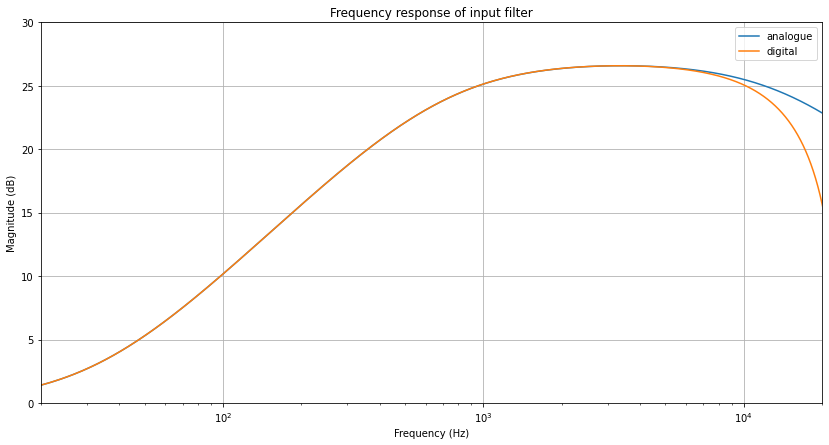

In [6]:
# input_filter.info
tf_s = (s**2 + 2.23219e+06*s + 4.52694e+08)/(1 * s**2 + 104527*s + 4.52694e+08)

n, d = sympy.fraction(tf_s)
n_poly = sympy.Poly(n, s)
d_poly = sympy.Poly(d, s)
B = n_poly.all_coeffs()
A = d_poly.all_coeffs()

tf = signal.lti([float(BB) for BB in B], [float(AA) for AA in A])
w, H = signal.freqresp(tf)

plt.figure()
plt.semilogx(w/2/np.pi, 20*np.log10(np.abs(H)), label="analogue")

B, A = bilinear_transform(tf_s)

print_as_cpp_coefficients(B, "B")
print_as_cpp_coefficients(A, "A")

b = substitute_parameter(B, {K: k})
a = substitute_parameter(A, {K: k})
f = signal.dlti(b, a)
w, H = signal.dfreqresp(f)

plt.semilogx(w/2/np.pi*rate, 20*np.log10(np.abs(H)), label="digital")
plt.title("Frequency response of input filter")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.xlim(20, 20e3)
plt.ylim(0, 30)
plt.legend()
plt.show()

## Gain control

There are two sets of functions, as this circuit has two switchable modes (OD1/OD2).

float B10 = 0.0198360655737705*K*g;
float B11 = 0;
float B12 = -0.0198360655737705*K*g;
float A10 = 9.32295081967213e-8*std::pow(K, 2)*g + 2.35e-5*K*g + 0.00198360655737705*K + 0.5;
float A11 = -1.86459016393443e-7*std::pow(K, 2)*g + 1.0;
float A12 = 9.32295081967213e-8*std::pow(K, 2)*g - 2.35e-5*K*g - 0.00198360655737705*K + 0.5;
float B20 = 0.11*K*g;
float B21 = 0;
float B22 = -0.11*K*g;
float A20 = 4.69953e-8*std::pow(K, 2)*g + 2.35e-5*K*g + 0.0009999*K + 0.5;
float A21 = -9.39906e-8*std::pow(K, 2)*g + 1.0;
float A22 = 4.69953e-8*std::pow(K, 2)*g - 2.35e-5*K*g - 0.0009999*K + 0.5;


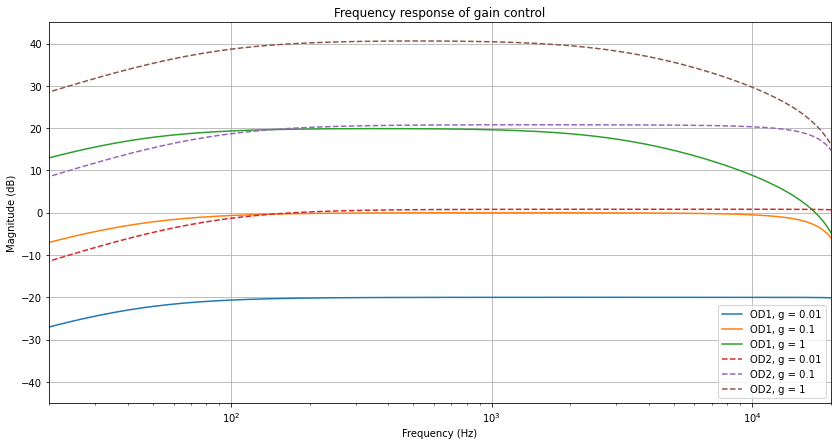

In [7]:
# OD1.info / OD2.info
C1 = 220e-9
C2 = 47e-12
R1 = 22e3
R2 = 100e3
Rg = sympy.symbols("Rg")
Rg_value = 1e6

B1 = [R1*Rg*C1, 0]
A1 = [R1*R2*Rg*C1*C2, R1*R2*C1 + R1*Rg*C2 + R2*Rg*C2, R1+R2]

B2 = [Rg*C1, 0]
R1 = 9.09e3
A2 = [R1*Rg*C1*C2, R1*C1 + Rg*C2, 1]

g = sympy.symbols("g")

tf1_s = ((B1[0]*s)/(A1[0]*s**2 + A1[1]*s + A1[2])).subs(Rg, Rg_value*g)
tf2_s = ((B2[0]*s)/(A2[0]*s**2 + A2[1]*s + A2[2])).subs(Rg, Rg_value*g)

B1z, A1z = bilinear_transform(tf1_s)
B2z, A2z = bilinear_transform(tf2_s)

print_as_cpp_coefficients(B1z, "B1")
print_as_cpp_coefficients(A1z, "A1")
print_as_cpp_coefficients(B2z, "B2")
print_as_cpp_coefficients(A2z, "A2")

G = [0.01, 0.1, 1]

plt.figure()
for B, A, label, linestyle in [[B1z, A1z, "OD1", "-"], [B2z, A2z, "OD2", "--"]]:
    for gg in G:
        subs = {K:k, g:gg}
        b = substitute_parameter(B, subs)
        a = substitute_parameter(A, subs)
            
        f = signal.dlti(b, a)
        w, H = signal.dfreqresp(f)
        
        # ignore divide by 0 errors
        with np.errstate(divide='ignore'):
            plt.semilogx(w/2/np.pi*rate, 20*np.log10(np.abs(H)), label=f"{label}, g = {gg}", linestyle=linestyle)

plt.legend()
plt.title("Frequency response of gain control")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.xlim(20, 20e3)
plt.ylim(-45, 45)
plt.show()

## Contour filter

/usr/lib/python3.9/site-packages/scipy/signal/filter_design.py:1630: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "


float B0 = 9.05251759610179e-11*std::pow(K, 3)*std::pow(p, 2) - 1.08075708355892e-10*std::pow(K, 3)*p + 1.13156469951272e-6*std::pow(K, 2)*std::pow(p, 2) - 1.15683089695001e-6*std::pow(K, 2)*p - 1.89606569211334e-8*std::pow(K, 2) - 0.000315827467966071*K*p - 0.000205739036275041*K - 0.0902364194188775;
float B1 = -1.81050351922036e-10*std::pow(K, 3)*std::pow(p, 2) + 2.16151416711785e-10*std::pow(K, 3)*p - 0.000631654935932142*K*p - 0.000411478072550081*K - 0.36094567767551;
float B2 = -2.26312939902545e-6*std::pow(K, 2)*std::pow(p, 2) + 2.31366179390002e-6*std::pow(K, 2)*p + 3.79213138422667e-8*std::pow(K, 2) - 0.541418516513265;
float B3 = 1.81050351922036e-10*std::pow(K, 3)*std::pow(p, 2) - 2.16151416711785e-10*std::pow(K, 3)*p + 0.000631654935932142*K*p + 0.000411478072550081*K - 0.36094567767551;
float B4 = -9.05251759610179e-11*std::pow(K, 3)*std::pow(p, 2) + 1.08075708355892e-10*std::pow(K, 3)*p + 1.13156469951272e-6*std::pow(K, 2)*std::pow(p, 2) - 1.15683089695001e-6*std::pow(K,

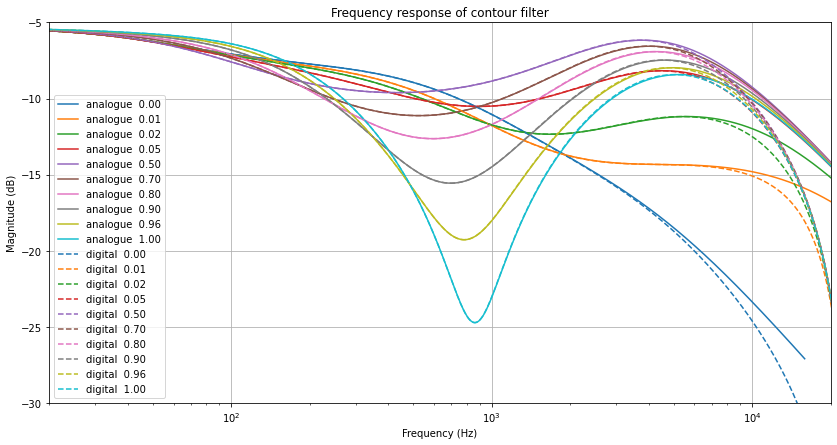

In [8]:
# contour.info
Rp1, Rp2, p = sympy.symbols("Rp1 Rp2 p")
Rp = 100e3
V1 = 1

exp = ((( 1.0032e-14 * Rp1 * Rp2 * V1 + 1.94495e-10 * Rp1 * V1 ) * s**3 +
        ( 1.254e-10 * Rp1 * Rp2 * V1 + 4.56e-07 * Rp1 * V1 + 1.76e-07 * Rp2 * V1 + 0.0034122 * V1 ) * s**2 +
        ( 0.0057 * Rp1 * V1 + 0.0022 * Rp2 * V1 + 8 * V1 ) * s + 100000 * V1) / 
       (( 3.88784e-19 * Rp1 * Rp2 + 7.53755e-15 * Rp1 ) * s**4 +
        ( 1.92511e-14 * Rp1 * Rp2 + 5.04208e-10 * Rp1 + 3.88784e-11 * Rp2 + 7.53755e-07 ) * s**3 + 
        ( 2.31614e-10 * Rp1 * Rp2 + 7.82459e-06 * Rp1 + 1.05904e-06 * Rp2 + 0.0297419 ) * s**2 +
        ( 0.0105279 * Rp1 + 0.0040634 * Rp2 + 170.06 ) * s + 184700))

exp_final = exp.subs({Rp1: Rp*p, Rp2: Rp*(1-p)})
n, d = sympy.fraction(exp_final)
n_poly = sympy.Poly(n, s)
d_poly = sympy.Poly(d, s)
B = n_poly.all_coeffs()
A = d_poly.all_coeffs()

P = [0, 0.01, 0.02, 0.05, 0.5, 0.7, 0.8, 0.9, 0.96, 1]
# plot response of analogue filter
for pp in P:
    b = substitute_parameter(B, {p: pp})
    a = substitute_parameter(A, {p: pp})

    tf = signal.lti(b, a)
    w, H = signal.freqresp(tf)
    plt.semilogx(w/2/np.pi, 20*np.log10(np.abs(H)), label=f"analogue {pp: .2f}")

tf = (B[0]*s**3 + B[1]*s**2 + B[2]*s + B[3])/(A[0]*s**4 + A[1]*s**3 + A[2]*s**2 + A[3]*s + A[4])
Bz, Az = bilinear_transform(tf)

print_as_cpp_coefficients(Bz, "B")
print_as_cpp_coefficients(Az, "A")

# plot response of digital filter
for pp in P:
    b = substitute_parameter(Bz, {p: pp, K: k})
    a = substitute_parameter(Az, {p: pp, K: k})

    tf = signal.dlti(b, a)
    w, H = signal.dfreqresp(tf)
    plt.semilogx(w/2/np.pi*rate, 20*np.log10(np.abs(H)), label=f"digital {pp: 0.2f}", linestyle='--')

plt.title("Frequency response of contour filter")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.xlim(20, 20e3)
plt.ylim(-30, -5)
plt.legend()
plt.show()

Notice how the response is non-linear here. Between 0 - 0.05, there is substantial high-cut. From 0.05 to 0.5 the response barely changes, then above 0.5 there is a mid-cut. It might be a nice improvement to add a function that transforms the parameter in order to linearise the effect.

Further improvement is to run the filters at an oversampled rate, or use another method to reduce the effect of frequency warping. This can be seen on the graph as a difference between the analog and digital response at high frequencies.

# Distortion

The distortion comes from a combination of diode clipping and a 12AX7 vacuum tube. A static waveshaper is used to simulate these circuits. This was created by entering the schematic into LTSpice, then running a slow DC ramp through the input.

To output the data from LTSpice, click on the node that should be exported (V(follower) in this case). This should make a plot appear. Now we can right click on the plot then navigate to File -> Export data as text. The output is not sampled uniformly, so we have to resample here.

In [139]:
# 9 decimal digits should be enough to exactly represent a 32-bit IEEE 754 float
def print_cpp_array(a):
    print("{", end="")
    for i in range(len(a)):
        if not i % 5:
            print("")
            
        print(f"{a[i]:11.10}, ", end="")
        
    print("\n}", end="")

        
print_cpp_array([1.000000001, 2., 3., 4., 5., 6.])

{
1.000000001,         2.0,         3.0,         4.0,         5.0, 
        6.0, 
}

In [141]:
time = []
output = []

with open('clipping_waveshape.txt') as csvDataFile:
    csvReader = csv.reader(csvDataFile, delimiter='\t')
    next(csvReader) # skip the header line
    for row in csvReader:
        time.append(float(row[0]))
        output.append(float(row[1]))
        
# the input voltage was -10 V to 10 V, with a linear ramp over time
input_voltage = (np.array(time)-0.5)*20

In [150]:
N = 100

def resample_by_interpolation(x, y, length):
    return np.interp(np.linspace(x[0], x[-1], length, endpoint=True), x, y)

output_resampled = resample_by_interpolation(input_voltage, output, N)
input_resampled = np.linspace(input_voltage[0], input_voltage[-1], N, endpoint=True)

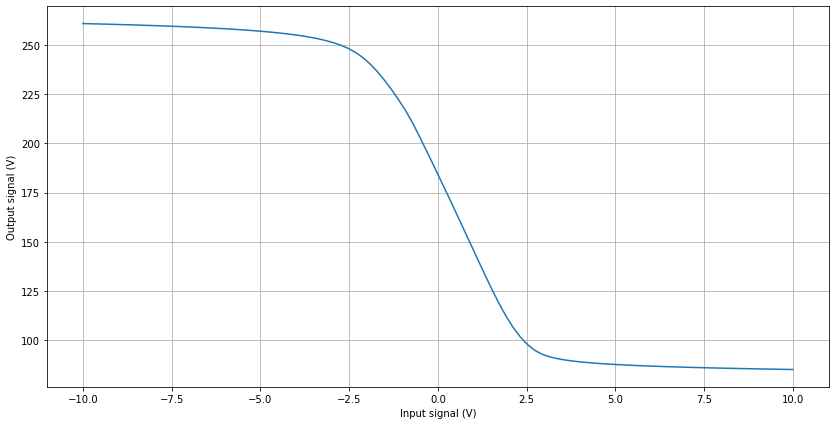

{
    260.874, 260.7859598, 260.6953072,  260.601432, 260.5041537, 
260.4031856, 260.2985207, 260.1896056,  260.076319, 259.9582966, 
259.8351546, 259.7065092, 259.5718914, 259.4308215, 259.2828199, 
259.1270814, 258.9629027, 258.7895337, 258.6060523, 258.4113474, 
258.2040441, 257.9827768, 257.7457712, 257.4909677,  257.215841, 
256.9175018, 256.5922455, 256.2355875, 255.8419352, 255.4041851, 
254.9131986, 254.3570307, 253.7197414, 252.9797121, 252.1071154, 
251.0601723, 249.8186298, 248.2374011, 246.2379769, 243.6984809, 
240.5224287, 236.6969109, 232.3051762, 227.4657723, 222.2539886, 
216.6160464, 210.1628519, 202.9424278, 195.5356801, 188.0209338, 
180.4120106, 172.7204129, 164.9578739,  157.138341, 149.2820719, 
141.4227325, 133.6224484, 125.9975098, 118.7442167, 112.1250619, 
106.3720184,  101.573245,  97.7060744, 94.80219447, 92.84731645, 
 91.5876897, 90.69125858,  90.0247106, 89.50066273, 89.07172653, 
88.71016277, 88.39855163, 88.12531192, 87.88239154, 87.66399733, 
87.46582

In [151]:
plt.plot(input_resampled, output_resampled)
plt.xlabel("Input signal (V)")
plt.ylabel("Output signal (V)")
plt.show()
print_cpp_array(output_resampled)